# [COM6513] Assignment: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**2 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**3 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**1 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500} and the dropout rate {e.g. 0.2, 0.5}. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**1 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**3 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices. You must provide detailed explanations of your implementation, provide a detailed analysis of the results (e.g. why a model performs better than other models etc.) including error analyses (e.g. examples and discussion/analysis of missclasifications etc.)  (**10 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

Class 1: Politics, Class 2: Sports, Class 3: Economy

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You **must** submit a Jupyter Notebook file (assignment_yourusername.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`, you need to have a Latex distribution installed e.g. MikTex or MacTex and pandoc). If you are unable to export the pdf via Latex, you can print the notebook web page to a pdf file from your browser (e.g. on Firefox: File->Print->Save to PDF).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results and discussion is as important as the implementation and accuracy of your models. Please be brief and consice in your discussion and analyses. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 26 Apr 2023** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(1230)
np.random.seed(1230)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
df_train = pd.read_csv('data_topic/train.csv',names=[0, 1])
df_test = pd.read_csv('data_topic/test.csv',names=[0, 1])
df_dev = pd.read_csv('data_topic/dev.csv',names=[0, 1])

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [3]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [4]:
#regex can be changed to  the token pattern to match all word characters (including digits and special characters) using the regular expression \w+
# x is a list of ngram_range=(1,2) unigram and bigram for an input string.
def extract_ngrams(x_raw, ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=stop_words, vocab=None):
    x_lower = x_raw.lower()
    tokens = re.findall(token_pattern, x_lower)
    if stop_words:
        tokens = [token for token in tokens if token not in stop_words]
        
    x = []
    data=[]
    for n in range(ngram_range[0], ngram_range[1]+1):
        for i in range(len(tokens)-n+1):
            n_gram = ' '.join(tokens[i:i+n])
            if vocab is None or n_gram in vocab:
                x.append(n_gram)
    #data = [y for y in zip(*[iter(x)])]
                
    
    return x







In [5]:
#Function to do the one-hot encoding of the labels

def one_hot(Y):
    one_hot_Y = np.zeros((len(Y), 3))
    one_hot_Y[np.arange(len(Y)), Y-1] = 1
    
    return one_hot_Y

In [291]:
#Converting Train Data to list.
x_raw_train = list(df_train[1])
y_true = list(df_train[0])

#Converting Dev Data to list.
x_dev_train = list(df_dev[1])
y_dev_true= list(df_dev[0])

#Converting Test Data to list.

x_test_train = list(df_test[1])
y_test_true= list(df_test[0])


#Remark - This train list contains duplicates, remove it...


### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [292]:
def get_vocab(X_raw, ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b(?!,)', stop_words=stop_words, min_df=0, keep_topN=2):
    
    # Create regex pattern to extract tokens
    #token_regex = re.compile(token_pattern)
    
    # Initialize document frequency Counter and n-gram count dictionary
    df = Counter()
    ngram_counts = {}
    
    # Iterate through each document
    for doc in X_raw:
        
       
        # Generate n-grams for document
        ngrams = extract_ngrams(doc,ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                stop_words=stop_words, vocab=None)
            
        # Update document frequency Counter for each unique n-gram
        df.update(ngrams)
            
        # Update n-gram count dictionary for each unique n-gram
        for ng in set(ngrams):
            ngram_counts[ng] = ngram_counts.get(ng,0) + 1
    
    # Filter out n-grams with document frequency below minimum threshold
    df = Counter({ng:count for ng,count in df.items() if count>=min_df})
    
    # Keep top-N most frequent n-grams if specified
    if keep_topN:
        vocab = set([ng for ng,_ in df.most_common(keep_topN)])
    else:
        vocab = set(df.keys())
        
    return vocab,df,ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [15]:
#Storing the returned values from get_vocab() in vocab_set, df_counter, ngram_dict respectively.
#input to the get_vocab() is x_raw_train whihch is a list of string each corresponding to the raw tet in a document.
        
vocab_set, df_counter, ngram_dict = get_vocab(x_raw_train , ngram_range=(1,2), token_pattern=r'\b[A-Za-z][A-Za-z]+\b(?!,)', stop_words=stop_words, min_df=2, keep_topN=None)

#vocab_list_feature  is a list of all the vocabs extracted using get_vocab()
vocab_list_feature = list(vocab_set)








12125

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [16]:


word_id=[]
# Create vocabulary id -> word dictionary
vocabid_to_word = dict(enumerate(vocab_list_feature))

# Create word -> vocabulary id dictionary
word_id_vocab  = {v:id for id,v in vocabid_to_word.items()}





### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [ ]:
x_dev_train = [extract_ngrams(i, ngram_range=(1,2), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=None) for i in x_dev_train]
train_list = [extract_ngrams(i, ngram_range=(1,2), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=None) for i in x_raw_train]


Then convert them into lists of indices in the vocabulary:

In [293]:
##Train Set
def list_of_id(doc,word_id_vocab):
    temp_doc = []
    
    for tup_ngram in doc:
        try:
            temp_doc.append(word_id_vocab[tup_ngram])
        except KeyError:
            temp_doc.append(0)
        
    return temp_doc

    
 #Converting list of words in a documnents in training and validation data to list of indices.     
train_set = [list_of_id(doc,word_id_vocab) for doc in train_list]
x_dev_train  = [list_of_id(doc,word_id_vocab) for doc in x_dev_train]
x_test_train= [list_of_id(doc,word_id_vocab) for doc in x_test_train]           
                


Put the labels `Y` for train, dev and test sets into arrays: 

In [294]:
#Converting true labels into one-hot encoded label for Train data
y_label = np.array(df_train[0])
y_label = one_hot(y_label)

#Converting true labels into one-hot encoded label for Dev data
y_dev_label = np.array(df_dev[0])
y_dev_label = one_hot(y_dev_label)

#Converting true labels into one-hot encoded label for Test data
y_test_label = np.array(df_test[0])
y_test_label = one_hot(y_test_label)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [234]:
def network_weights1(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[50], num_classes=3, init_val = 0.5):
    
    W={}
    embedding = np.random.uniform(size = (vocab_size,embedding_dim), low = -0.1, high = 0.1)
    output_matrix = np.random.uniform(size = (embedding_dim,num_classes), low = -0.1, high = 0.1)
    W[0]=embedding
    W[1]=output_matrix
    
    
    return W
    

In [239]:



def network_weights(vocab_size=1000, embedding_dim=300,
                    hidden_dims=[50], num_classes=3, init_val=0.5):

    W = {}
    embedding = np.random.uniform(size=(vocab_size, embedding_dim), low=-0.1, high=0.1)
    W[0] = embedding
    prev_dim = embedding_dim
    # Initialize the weight matrices for the hidden layers
    if (len(hidden_dims) != 0) :
        for i, hidden_dim in enumerate(hidden_dims):
            weight_matrix = np.random.uniform(size=(prev_dim, hidden_dim), low=-0.1, high=0.1)
            W[i + 1] = weight_matrix
            prev_dim = hidden_dim
        output_matrix = np.random.uniform(size=(hidden_dims[-1], num_classes), low=-0.1, high=0.1)
        W[len(hidden_dims) + 1] = output_matrix
    else:
        # Initialize the output matrix
        output_matrix = np.random.uniform(size=(embedding_dim, num_classes), low=-0.1, high=0.1)
        W[len(hidden_dims) + 1] = output_matrix

    return W

# Example usage




Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [42]:
#Softmax implementation with x-max(x) to overcome the overflow issue raised.
def stable_softmax(x):
    z = x - max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    softmax = numerator/denominator

    return softmax.tolist()







Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [41]:
def categorical_loss(y, y_preds):
   
    
    # Compute the loss
    loss = -np.sum(y * np.log(y_preds))
    loss = loss/len(y_preds)
    
    
    
    
    return loss

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [40]:
def relu(input_list):
    # convert input list to numpy array
    input_array = np.array(input_list)
    
    # apply ReLU function element-wise using numpy
    output_array = np.maximum(input_array, 0)
    
    # convert output array back to list
    output_list = output_array.tolist()
    
    # return the output list
    return output_list

    
    
    


def relu_derivative(input_list):
    # convert input list to numpy array
    input_array = np.array(input_list)
    
    # create an array of zeros with the same shape as the input array
    zeros_array = np.zeros_like(input_array)
    
    # create an array of ones with the same shape as the input array
    ones_array = np.ones_like(input_array)
    
    # set elements in the zeros array to 1 if the corresponding element in the input array is greater than 0
    zeros_array[input_array > 0] = 1
    
    # compute the derivative of the ReLU function element-wise using numpy
    output_array = zeros_array * ones_array
    
    # convert output array back to list
    output_list = output_array.tolist()
    
    # return the output list
    return output_list


During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [36]:
def dropout_mask(size, dropout_rate):
    dropout_vec = np.ones(size)
    mask = np.random.rand(size) < dropout_rate
    dropout_vec[mask] = 0

    
    return dropout_vec
    
    

In [21]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
[1. 1. 1. 0. 0. 1. 1. 1. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [295]:
def forward_pass(x, W, dropout_rate):
    
    dic = np.array(W[0])
    h_vecs = np.zeros(300).astype('float32')
    for i in x:
        h_vec = np.zeros(300).astype('float32')
        #used is instance to avoid any nan values in the vector , to resolve the error raised.
        if isinstance(i, int):
            
            h_vec = dic[i]
            #Adding all the embedding vector of n-grams in a document
            h_vecs = h_vecs + h_vec
            
            
        else:
            
            h_vec = np.zeros(300)
            h_vecs = h_vecs + h_vec
       

    out_vals = {}
    
    #Initialization of lists
    #out_vals is a Dictionary used to store all the below mentioned lists A1,A2,Z1,Z2
    #A1=[] is to store the embedding vector passed through Relu
    #A2=[] to store the output of stable_softmax(Z2)
    #Z1=[] to store the initial embedding vector h_vecs
    #Z2=[] to store the dot product between A1 and W[1]
    A1=[]
    A2=[]
    Z1=[]
    Z2=[]
    
    
    
    
    dropout_vecs = dropout_mask(300, dropout_rate)
    
    h_vecs *= dropout_vecs 
    out_vals = {'Z1': [], 'A1': [], 'Z2': [], 'A2': [], 'Z3': [], 'A3': []}
    
    
    Z1 = h_vecs
    out_vals['Z1'].append(Z1)
    A1 = relu(Z1)
    out_vals['A1'].append(A1)
    
    Z2 = np.dot(A1,W[1]) #Z1 = 1 * 50
    out_vals['Z2'].append(Z2)

    # forward pass through output layer
    A2=stable_softmax(Z2)
    out_vals['A2'].append(A2)
    
   
    
    return out_vals
    

In [279]:
a = forward_pass(x_dev_train[2], W, dropout_rate=0.4)
a['A2']

[[0.7656803055477004, 0.009001335986667141, 0.2253183584656325]]

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [391]:
#update_params_AE - is used to update parameters of Average embeddings

def update_params_AE(W,dW1,dW2,learningrate,freeze_emb):
    if freeze_emb == True:
        
        W[1]=W[1]-learningrate*dW2
    else:
        
        W[1]=W[1]-learningrate*dW2
        W[0]=W[0]-learningrate*dW1
    return W

In [387]:
def backward_prop( y, W, out_vals, learningrate,print=True,freeze_emb=True):
    y=np.array(y)
    m = y.size

    #dZ2 is used to calculate softmax derivative or difference between predicted and  label document wise.
    #dZ1 is used to store dot product of W[1] matrix and A2.T vector
    #dW1 and dW2 are the 2 variable used to store the value that is used to update the weights holds the same shape as respective weight matrix w[1] and W[0]
    
    Z1=np.array(out_vals['Z1'][0]).reshape(1,-1)
    Z2=np.array(out_vals['Z2'][0]).reshape(1,-1)
    
    A1=np.array(out_vals['A1'][0]).reshape(1,-1)
    A2= np.array(out_vals['A2'][0]).reshape(1,-1)
    
    
    dZ2 = A2 - y  #1 * 3
    dW2 = np.dot(A1.T,dZ2) #300 * 3
    
    dZ1 = np.dot(W[1],A2.T) * relu_derivative(A1) #300 * 300
    dW1 = np.dot(W[0],dZ1) #47003 * 300
   
    W = update_params_AE(W,dW1,dW2,learningrate,freeze_emb=True)
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [389]:
def SGD(X_tr, Y_tr,X_dev,Y_dev ,W, learningrate, dropout, epochs=5,print_progress=True, tolerance = 0.001, freeze_emb = True):
    #To store the history of losses of train and dev data to plot and analyse .
    training_loss_history = []
    validation_loss_history = []
    count=0
    
    for epoch in range(epochs):
        



        #shuffling the training data
        # pair the elements of the two lists using zip()
        paired_lists = list(zip(X_tr, Y_tr))

        # shuffle the paired lists
        random.shuffle(paired_lists)

        # unzip the paired lists back into separate lists
        shuffled_list1, shuffled_list2 = zip(*paired_lists)
            
        
        # initialize training loss for this epoch
        train_loss = 0.0
        
        accuracy = 0.0
        accuracy_percentage = 0.0
        accuracy_dev = 0.0
        accuracy_percentage_val = 0.0
        val_loss = 0.0
        
        
      # perform stochastic gradient descent on the training data
        for i in range(len(X_tr)):
            loss1= 0.0
            loss = 0.0
            y_preds=[]
            y_preds1=[]
            out_vals=[]
            out_put=[]
            x1 =[]
            y=[]
            y1=[]
            predicted_label = []
            predicted_label_dev=[]
            true_label = []
            true_label_dev=[]

            
            x = shuffled_list1[i]
            y = shuffled_list2[i]

            # perform forward pass
            out_vals = forward_pass(x, W, dropout_rate=dropout)
            W = backward_prop( y, W, out_vals, learningrate,freeze_emb=True)
            
            y_preds = out_vals['A2'][0]
            
            loss = categorical_loss(y,y_preds)
            train_loss = train_loss + loss
            predicted_label = np.argmax(y_preds)
            true_label = np.argmax(y)
            if (predicted_label == true_label):
                 accuracy = accuracy + 1
            # compute loss and update training loss for this epoch
     
        # compute average training loss for this epoch
        train_loss = train_loss / len(X_tr)
        accuracy_percentage = (accuracy / len(X_tr))*100
        
        
        # compute validation loss for this epoch
        
        for i in range(len(X_dev)):
            x1 = X_dev[i]
            y1 = Y_dev[i]

            # perform forward pass
            out_put = forward_pass(x1, W, dropout_rate=dropout)

            #compute loss and update validation loss for this epoch
            y_preds1 = out_put['A2'][0]
            loss1 = categorical_loss(y1, y_preds1)
            val_loss = val_loss + loss1
            predicted_label_dev = np.argmax(y_preds1)
            true_label_dev = np.argmax(y1)
            if (predicted_label_dev == true_label_dev):
                 accuracy_dev = accuracy_dev + 1
        # compute average validation loss for this epoch
        val_loss = val_loss / len(X_dev)
        accuracy_percentage_val = (accuracy_dev / len(X_dev))*100
        
        # save loss history for plotting later
        training_loss_history.append(train_loss)
        validation_loss_history.append(val_loss)

        # print progress if desired
        if print_progress:
            print(f"Epoch {epoch+1} - Training Loss: {train_loss:.4f} - Train_Accuracy: {accuracy_percentage:.4f}- val Loss: {val_loss:.4f} - val_Accuracy: {accuracy_percentage_val:.4f}")
        

        # check if improvement is smaller than tolerance and stop training if true
        #if epoch > 0 and (validation_loss_history[-2] - validation_loss_history[-1])  < tolerance:
            
            #print(f"\nTraining stopped after {epoch+1} epochs due to small improvement in validation loss.")
            #break

    return W, training_loss_history, validation_loss_history


Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [392]:
W = network_weights(vocab_size=len(vocab_list_feature),embedding_dim=300,
                    hidden_dims=[], num_classes=3)



W, loss_tr, dev_loss = SGD(train_set, y_label,x_dev_train,y_dev_label,
                            W,learningrate=0.001, 
                            dropout=0.4,epochs=5,print_progress=True,tolerance = 0.001,freeze_emb=False)


Epoch 1 - Training Loss: 0.3758 - Train_Accuracy: 36.7500- val Loss: 0.8542 - val_Accuracy: 37.3333
Epoch 2 - Training Loss: 0.3604 - Train_Accuracy: 41.5000- val Loss: 1.2838 - val_Accuracy: 30.6667
Epoch 3 - Training Loss: 0.3496 - Train_Accuracy: 44.6667- val Loss: 1.0477 - val_Accuracy: 32.6667
Epoch 4 - Training Loss: 0.3494 - Train_Accuracy: 46.7083- val Loss: 1.5127 - val_Accuracy: 38.6667
Epoch 5 - Training Loss: 0.3460 - Train_Accuracy: 47.0833- val Loss: 1.5161 - val_Accuracy: 36.0000


Plot the learning process:

<Axes: title={'center': 'Validation Loss'}>

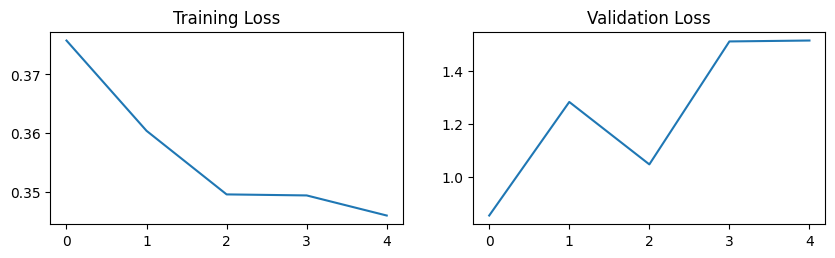

In [393]:
plots = {'Training': loss_tr,'Validation':dev_loss}
plots_df = pd.DataFrame(plots)
fig, axes = plt.subplots(1,2, figsize=(10, 2.5))
plots_df.Training.plot(ax = axes[0], title = "Training Loss")
plots_df.Validation.plot(ax = axes[1], title = "Validation Loss")

In [ ]:
Compute accuracy, precision, recall and F1-Score:

In [297]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['A2']) 
            for x,y in zip(x_test_train,y_test_label)]
#add +1 to all element in preds_te
preds_te = [x+1 for x in preds_te]
print('Accuracy:', accuracy_score(y_test_true,preds_te))
print('Precision:', precision_score(y_test_true,preds_te,average='macro'))
print('Recall:', recall_score(y_test_true,preds_te,average='macro'))
print('F1-Score:', f1_score(y_test_true,preds_te,average='macro'))
del W
gc.collect()

Accuracy: 0.3333333333333333
Precision: 0.1111111111111111
Recall: 0.3333333333333333
F1-Score: 0.16666666666666666


/Users/ankit/opt/anaconda3/envs/ankit_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95

### Discuss how did you choose model hyperparameters ? 

#To choose the model Hyperparameter tried 3 different possibility of learning rate and dropout.
1.learning-rate =0.0003  , Dropout - 0.1
Epoch 1 - Training Loss: 0.3795 - Train_Accuracy: 33.4167- val Loss: 1.0621 - val_Accuracy: 29.3333
Epoch 2 - Training Loss: 0.3717 - Train_Accuracy: 37.3750- val Loss: 1.3668 - val_Accuracy: 34.0000

2.learning-rate = 0.0002 , Dropout - 0.4
Epoch 1 - Training Loss: 0.4099 - Train_Accuracy: 33.3333- val Loss: 1.8267 - val_Accuracy: 32.0000
Epoch 2 - Training Loss: 0.3846 - Train_Accuracy: 33.5417- val Loss: 1.2724 - val_Accuracy: 30.0000
Epoch 3 - Training Loss: 0.3806 - Train_Accuracy: 33.7917- val Loss: 1.1476 - val_Accuracy: 37.3333


3.learning-rate = 0.0002 , Dropout - 0.5
Epoch 1 - Training Loss: 0.3792 - Train_Accuracy: 33.5417- val Loss: 1.1419 - val_Accuracy: 39.3333
Epoch 2 - Training Loss: 0.3785 - Train_Accuracy: 34.2083- val Loss: 1.2372 - val_Accuracy: 35.3333
Epoch 3 - Training Loss: 0.3717 - Train_Accuracy: 35.9167- val Loss: 1.0575 - val_Accuracy: 36.0000
Epoch 4 - Training Loss: 0.3705 - Train_Accuracy: 37.3333- val Loss: 0.9454 - val_Accuracy: 36.0000



Conclusion- model is performing good with training data but is unstable with validation data , on incresing the dropout to 0.4/0.5 model performs comparatively better as in case of case 3.

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [375]:
def get_glove_embeddings(f_zip, f_txt, vocab, emb_size=300):
    
    w_emb = np.zeros((len(vocab), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[vocab[word]] +=emb
    return w_emb

In [154]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word_id_vocab,emb_size=300 )

In [163]:
w_glove.shape

(12125, 300)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [395]:
W = network_weights(vocab_size=len(vocab_list_feature),embedding_dim=300,
                    hidden_dims=[], num_classes=3)
W[0]=w_glove
W, loss_tr, dev_loss = SGD(train_set, y_label,x_dev_train,y_dev_label,
                            W,learningrate=0.0001, 
                            dropout=0.5,epochs=5,print_progress=True,freeze_emb=True)

Epoch 1 - Training Loss: 0.4758 - Train_Accuracy: 50.9583- val Loss: 4.8964 - val_Accuracy: 30.6667
Epoch 2 - Training Loss: 0.3118 - Train_Accuracy: 63.8750- val Loss: 3.9341 - val_Accuracy: 30.6667
Epoch 3 - Training Loss: 0.2785 - Train_Accuracy: 69.0833- val Loss: 3.2468 - val_Accuracy: 38.0000
Epoch 4 - Training Loss: 0.2408 - Train_Accuracy: 71.4583- val Loss: 3.6602 - val_Accuracy: 32.0000
Epoch 5 - Training Loss: 0.2366 - Train_Accuracy: 73.0000- val Loss: 3.0714 - val_Accuracy: 32.0000


<Axes: title={'center': 'Validation Loss'}>

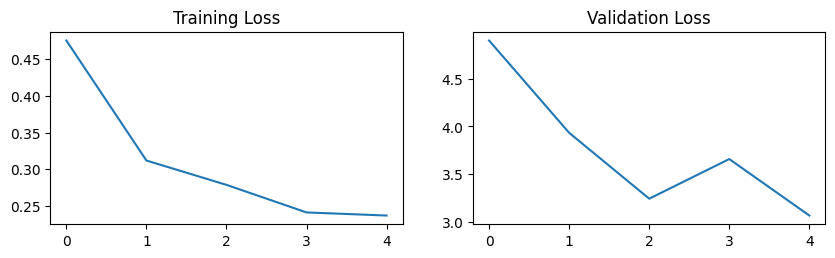

In [396]:
plots = {'Training': loss_tr,'Validation':dev_loss}
plots_df = pd.DataFrame(plots)
fig, axes = plt.subplots(1,2, figsize=(10, 2.5))
plots_df.Training.plot(ax = axes[0], title = "Training Loss")
plots_df.Validation.plot(ax = axes[1], title = "Validation Loss")

In [400]:
preds_te1 = [np.argmax(forward_pass(x, W, dropout_rate=0.4)['A2']) 
            for x,y in zip(x_test_train,y_test_label)]
#add +1 to all element in preds_te
preds_te1 = [x+1 for x in preds_te1]
print('Accuracy:', accuracy_score(y_test_true,preds_te1))
print('Precision:', precision_score(y_test_true,preds_te1,average='macro'))
print('Recall:', recall_score(y_test_true,preds_te1,average='macro'))
print('F1-Score:', f1_score(y_test_true,preds_te1,average='macro'))
del W
gc.collect()

Accuracy: 0.33444444444444443
Precision: 0.34344541654397176
Recall: 0.3344444444444445
F1-Score: 0.3262183060880515


### Discuss how did you choose model hyperparameters ? 

#To choose the model Hyperparameter tried 3 different possibility of learning rate and dropout.
1.learning-rate =0.0001  , Dropout - 0.4
Epoch 1 - Training Loss: 0.3795 - Train_Accuracy: 53.4167- val Loss: 20.0621 - val_Accuracy: 29.3333
Epoch 2 - Training Loss: 0.2717 - Train_Accuracy: 57.3750- val Loss: 15.3668 - val_Accuracy: 34.0000

2.learning-rate = 0.0001 , Dropout - 0.1
Epoch 1 - Training Loss: 0.3792 - Train_Accuracy: 59.9583- val Loss: 4.9970 - val_Accuracy: 36.6667
Epoch 2 - Training Loss: 0.2464 - Train_Accuracy: 76.2083- val Loss: 4.6563 - val_Accuracy: 37.3333
Epoch 3 - Training Loss: 0.2447 - Train_Accuracy: 78.0417- val Loss: 4.6404 - val_Accuracy: 35.3333


3.learning-rate = 0.0001 , Dropout - 0.5
Epoch 1 - Training Loss: 0.4758 - Train_Accuracy: 50.9583- val Loss: 4.8964 - val_Accuracy: 30.6667
Epoch 2 - Training Loss: 0.3118 - Train_Accuracy: 63.8750- val Loss: 3.9341 - val_Accuracy: 30.6667
Epoch 3 - Training Loss: 0.2785 - Train_Accuracy: 69.0833- val Loss: 3.2468 - val_Accuracy: 38.0000



Conclusion- Model is performing good with training data also slightly stable with validation data compare to average embedding, on incresing the dropout to 0.5 model performs comparatively better, it reduces the overfitting issue faced in Average embedding case.

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [311]:
def forward_pass_DA(x, W, dropout_rate):
    
    dic = np.array(W[0])
    h_vecs = np.zeros(300).astype('float32')
    for i in x:
        h_vec = np.zeros(300).astype('float32')
        if isinstance(i, int):
            
            h_vec = dic[i]
            #Adding all the embedding vector of n-grams in a document
            h_vecs = h_vecs + h_vec
            
            
        else:
            
            h_vec = np.zeros(300)
            h_vecs = h_vecs + h_vec
       

    out_vals = {}
    #Initialization of lists
    #out_vals is a Dictionary used to store all the below mentioned lists A1,A2,A3Z1,Z2,Z3
    #A1=[] is to store the embedding vector passed through Relu
    #A2=[] to store the output of Relu(Z2)
    #A3=[] to store the output of stable_softmax(Z3)
    #Z1=[] to store the initial embedding vector h_vecs
    #Z2=[] to store the dot product between A1 and W[1]
    #Z3=[] to store the dot product between A2 and W[2]
    
    A1=[]
    A2=[]
    Z1=[]
    Z2=[]
    A3=[]
    Z3=[]
    
    
    dropout_vecs = dropout_mask(300, dropout_rate)
    
    h_vecs *= dropout_vecs 
    out_vals = {'Z1': [], 'A1': [], 'Z2': [], 'A2': [], 'Z3': [], 'A3': []}
    
    
    Z1 = h_vecs
    
    out_vals['Z1'].append(Z1)
    A1 = relu(Z1)
    out_vals['A1'].append(A1)
    
    Z2 = np.dot(A1,W[1]) 
    out_vals['Z2'].append(Z2)
    A2 = relu(Z2)
    out_vals['A2'].append(A2)
    Z3 = np.dot(A2,W[2])
    out_vals['Z3'].append(Z3)
    A3=stable_softmax(Z3)
        
    
    # forward pass through output layer
    out_vals['A3'].append(A3)
   
    
    return out_vals
    

In [346]:
def update_params(W,dW2,dW3,learningrate,freeze_emb):
    if freeze_emb == True:
        W[2]=W[2]-learningrate*dW3
        W[1]=W[1]-learningrate*dW2

    return W

In [347]:
def backward_prop_DA( y, W, out_vals, learningrate,print=True,freeze_emb=True):
    y=np.array(y)
    m = y.size

    
    
    Z1=np.array(out_vals['Z1'][0]).reshape(1,-1)
    Z2=np.array(out_vals['Z2'][0]).reshape(1,-1)
    Z3=np.array(out_vals['Z3'][0]).reshape(1,-1)
    A1=np.array(out_vals['A1'][0]).reshape(1,-1)
    A2= np.array(out_vals['A2'][0]).reshape(1,-1)
    A3= np.array(out_vals['A3'][0]).reshape(1,-1)
    
    dZ3 = A3 - y  
    dW3 = np.dot(A2.T,dZ3)
    
    dZ2 = np.dot(W[2],dZ3.T) * relu_derivative(A2) 
    dW2 = np.dot(W[1],dZ2) 
    
    

    if freeze_emb == True:
        W = update_params(W,dW2,dW3,learningrate,freeze_emb=True)
       
    
    
    return W

In [348]:
def SGD_DA(X_tr, Y_tr,X_dev,Y_dev ,W, lr, dropout, epochs=5,print_progress=True,freeze_emb=False):
    training_loss_history = []
    validation_loss_history = []
    
    for epoch in range(epochs):
        



        #shuffling the training data
        # pair the elements of the two lists using zip()
        paired_lists = list(zip(X_tr, Y_tr))

        # shuffle the paired lists
        random.shuffle(paired_lists)

        # unzip the paired lists back into separate lists
        shuffled_list1, shuffled_list2 = zip(*paired_lists)
            
        
        # initialize training loss for this epoch
        train_loss = 0.0
        loss = 0.0
        accuracy = 0.0
        accuracy_percentage = 0.0
        accuracy_dev = 0.0
        accuracy_percentage_val = 0.0
        val_loss = 0.0
        loss1= 0.0
        
      # perform stochastic gradient descent on the training data
        for i in range(len(X_tr)):
            y_preds=[]
            y_preds1=[]
            out_vals=[]
            out_put=[]
            y=[]
            y1=[]
            predicted_label = []
            predicted_label_dev=[]
            true_label = []
            true_label_dev=[]

            #shuffled x and y
            x = shuffled_list1[i]
            y = shuffled_list2[i]

            # perform forward pass
            out_vals = forward_pass_DA(x, W, dropout_rate=dropout)
            W = backward_prop_DA( y, W, out_vals, lr,freeze_emb)
            
            y_preds = out_vals['A3'][0]
            
            loss = categorical_loss(y,y_preds)
            train_loss = train_loss + loss
            predicted_label = np.argmax(y_preds)
            true_label = np.argmax(y)
            if (predicted_label == true_label):
                 accuracy = accuracy + 1
            # compute loss and update training loss for this epoch
     
        # compute average training loss for this epoch
        train_loss = train_loss / len(X_tr)
        accuracy_percentage = (accuracy / len(X_tr))*100
        
        
        # compute validation loss for this epoch
        
        for i in range(len(X_dev)):
            x1 = X_dev[i]
            y1 = Y_dev[i]

            # perform forward pass
            out_put = forward_pass_DA(x1, W, dropout_rate=dropout)

            #compute loss and update validation loss for this epoch
            y_preds1 = out_put['A3'][0]
            loss1 = categorical_loss(y1, y_preds1)
            val_loss =val_loss + loss1
            predicted_label_dev = np.argmax(y_preds1)
            true_label_dev = np.argmax(y1)
            if (predicted_label_dev == true_label_dev):
                 accuracy_dev = accuracy_dev + 1
        # compute average validation loss for this epoch
        val_loss =val_loss / len(X_dev)
        accuracy_percentage_val = (accuracy_dev / len(X_dev))*100
        
        # save loss history for plotting later
        training_loss_history.append(train_loss)
        validation_loss_history.append(val_loss)

        # print progress if desired
        if print_progress:
            print(f"Epoch {epoch+1} - Training Loss: {train_loss:.4f} - Train_Accuracy: {accuracy_percentage:.4f}- val Loss: {val_loss:.4f} - val_Accuracy: {accuracy_percentage_val:.4f}")
        

        # check if improvement is smaller than tolerance and stop training if true
        if epoch > 0 and (validation_loss_history[-2] - validation_loss_history[-1]) < tolerance:
            print(f"\nTraining stopped after {epoch+1} epochs due to small improvement in validation loss.")
            break

    return W, training_loss_history, validation_loss_history


In [404]:
W = network_weights(vocab_size=len(vocab_list_feature),embedding_dim=300,
                    hidden_dims=[64], num_classes=3)
W[0]=w_glove
W, loss_tr, dev_loss = SGD_DA(train_set, y_label,x_dev_train,y_dev_label,
                            W,lr=0.001, 
                            dropout=0.4,epochs=5,print_progress=True,freeze_emb=True)

Epoch 1 - Training Loss: 0.3596 - Train_Accuracy: 51.1250- val Loss: 3.8743 - val_Accuracy: 34.0000
Epoch 2 - Training Loss: 0.3219 - Train_Accuracy: 57.0417- val Loss: 3.3658 - val_Accuracy: 26.6667
Epoch 3 - Training Loss: 0.3099 - Train_Accuracy: 58.9583- val Loss: 2.6263 - val_Accuracy: 38.0000
Epoch 4 - Training Loss: 0.3082 - Train_Accuracy: 60.5833- val Loss: 2.7420 - val_Accuracy: 33.3333
Epoch 5 - Training Loss: 0.3064 - Train_Accuracy: 61.0833- val Loss: 2.6527 - val_Accuracy: 36.0000


<Axes: title={'center': 'Validation Loss'}>

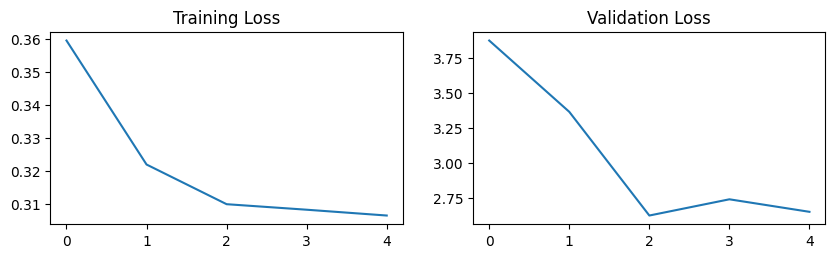

In [405]:
plots = {'Training': loss_tr,'Validation':dev_loss}
plots_df = pd.DataFrame(plots)
fig, axes = plt.subplots(1,2, figsize=(10, 2.5))
plots_df.Training.plot(ax = axes[0], title = "Training Loss")
plots_df.Validation.plot(ax = axes[1], title = "Validation Loss")

In [463]:
preds_te2 = [np.argmax(forward_pass_DA(x, W, dropout_rate=0.3)['A3']) 
            for x,y in zip(x_test_train,y_test_label)]
#add +1 to all element in preds_te
preds_te2 = [x+1 for x in preds_te2]
print('Accuracy:', accuracy_score(y_test_true,preds_te2))
print('Precision:', precision_score(y_test_true,preds_te2,average='macro'))
print('Recall:', recall_score(y_test_true,preds_te2,average='macro'))
print('F1-Score:', f1_score(y_test_true,preds_te2,average='macro'))
del W
gc.collect()

Accuracy: 0.34555555555555556
Precision: 0.3400611793901718
Recall: 0.34555555555555556
F1-Score: 0.30825034040730503


### Discuss how did you choose model hyperparameters ? 

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |0.1111111111111111 |0.3333333333333333   |0.16666666666666666   |0.3333333333333333  |
| Average Embedding (Pre-trained)  | 0.34344541654397176  | 0.3344444444444445  | 0.3262183060880515  |0.33444444444444443   |
| Average Embedding (Pre-trained) + X hidden layers    | 0.3400611793901718  |  0.34555555555555556|   0.30825034040730503|   0.34555555555555556|


Please discuss why your best performing model is better than the rest and provide a bried error analaysis.

I think the best performing model is the Average Embedding (Pre-trained) + X hidden layers.
Below is the explanation:

In Average Embedding - Model is trained on limited number of tokens ,The best performing model is chosen based on the loss reduction per epoch on hyperparameter(dropout an learning rate)
When Accuracyand precision is calculated on test data Accuracy: 0.3333333333333333 Precision: 0.1111111111111111,Recall: 0.3333333333333333, F1-Score: 0.16666666666666666.We can observe here is close to that of training and validation data but the precision is very low.
Also it missclassifies most of the 

In Average Embedding(pre-trained) - As the model is using pretrained weights it performs better that average embeddings precision,accuracy , and recall is better than average embedding.Loss reduces per epoch , but validation loss is still unstable. one possible reason could be because of lack of bias or regularisation.Because on increasing the dropout it performs better.(Model in the average embedding case and Average Embedding (Pre-trained) tends to overfit training data.)

In Average Embedding (Pre-trained) + X hidden layers -  Model is using pretrained weights and 1 hidden layer ,it performs better than embeddings and average embeddings in terms steady decrease in loss but the precision and recall remain almost the same. one reason for this could be distribution of tokens in test data.
To explain my point here are some examples.
sentence1 - Great Britain #39;s performances in the Olympic Games made a dramatic and unexpected improvement yesterday as they won a silver and three bronze medals. They were also guaranteed at least a silver medal in badminton #39;s mixed doubles.
correct - sports
predicted - politics
Sentence 2 - " LONDON (Reuters) - The dollar dipped to a four-week low  against the euro on Monday before rising slightly on  profit-taking, but steep oil prices and weak U.S. data  continued to fan worries about the health of the world's  largest economy."
correct - economy
predicted - politics
Sentence 3 - 'NEW YORK (CNN/Money) - Money managers are growing more pessimistic about the economy, corporate profits and US stock market returns, according to a monthly survey by Merrill Lynch released Tuesday. '
correct - economy
predicted - politics

From the examples it can be observed that if there is a mention of a "country Name" it classifies it as Political and as most of the article in the test set are with names of the countries therefore model makes mistakes in clasification.
conclusion - Possible solution could be if we can understand which ngram is important to classify a article then it would improve the classification. 
"Attention is all what a model need"



In [457]:
pred_ex = [np.argmax(forward_pass_DA(x_test_train[609], W, dropout_rate=0.3)['A3'])+1]
y_test_true[609]


3

In [458]:
pred_ex

[1]

In [459]:
y_test = list(df_test[1])
y_test[609]

'NEW YORK (CNN/Money) - Money managers are growing more pessimistic about the economy, corporate profits and US stock market returns, according to a monthly survey by Merrill Lynch released Tuesday. '